In [1]:
using JLD2
using PyPlot
using CSV
using ProgressMeter
using DataFrames
using Statistics
using StatsBase
using Distributions
using Distances

include("../src/modelisation.jl")
using .colocalization_modelisation

# Open simulation files

In [2]:
parameters_path = "/home/floric/Documents/julia/Random co-localization simulation/output/colocalization_simulation_parameters.csv"
result_path = "/home/floric/Documents/julia/Random co-localization simulation/output/"
pairwise_filename = "colocalization_pairwise_counts.jld2"
truth_table_filename = "colocalization_truth_table.jld2"
output_path = "/home/floric/Documents/julia/"

"/home/floric/Documents/julia/"

## Co-localization array

In [3]:
pairwise_data = jldopen(result_path*pairwise_filename, "r") do file
    read(file,"colocalization_counts")
end
simulation_number, distribution_number,_ = size(pairwise_data)

(100000, 7, 7)

In [4]:
truth_table, truth_table_index,shape = jldopen(result_path*truth_table_filename, "r") do file
    println(keys(file))
    read(file,"colocalization_truth_table"), read(file,"colocalization_truth_table_index"), read(file, "shape")
end
simulation_number,spot_per_simulation, distribution_number = size(truth_table)
print("truth_table : ", size(truth_table))
print("truth_table_index : ", size(truth_table_index))

["colocalization_truth_table", "colocalization_truth_table_index", "shape"]
truth_table : (100000, 1510, 7)truth_table_index : (1510,)

## Parameters frame

In [5]:
parameters = sort(CSV.read(parameters_path, DataFrame))
parameters

Row,distribution_id,abudancy
,Int64,Int64
1,1,10
2,2,50
3,3,100
4,4,200
5,5,250
6,6,400
7,7,500


## Plot simulation vs model

In [6]:
volume = prod(shape)

24964

In [7]:
function posterior_predictive_check(expectancy :: Real, std :: Real, data :: Vector, simulation_number = 10000, metric= mean)
    expected_distribution = Normal(expectancy, std)
    sample_size = length(data)

    T_obs = metric(data)
    
    sim_stats = Array{Float64,1}(undef,simulation_number)
    for sim in 1:simulation_number
        y_rep = rand(expected_distribution, sample_size)
        sim_stats[sim] = metric(y_rep)
    end
    println(mean(T_obs .- sim_stats))
    println(sim_stats)
    
    return mean(sim_stats .>= T_obs)
end

posterior_predictive_check (generic function with 3 methods)

In [8]:
mean_measure(data) = round(mean(data), digits = 1) 

mean_measure (generic function with 1 method)

In [9]:
distribution_query = 7
distribution_anchor = 6
abundancy1 = parameters[distribution_query, "abudancy"]
abundancy2 = parameters[distribution_anchor, "abudancy"]


data = sum(truth_table[:,truth_table_index .== distribution_query ,distribution_anchor], dims=2)
data = reshape(data, length(data))

expectancy = colocalization_modelisation.colocalization_expectancy(
    abundancy1,
    abundancy2,
    volume
)
distrib_std = colocalization_modelisation.colocalization_std(
    abundancy1,
    abundancy2,
    volume
)

posterior_predictive_check(expectancy, distrib_std, data, 10000, mean)



-0.008310153077865421
[7.952357770898649, 7.950458099496574, 7.963224342682315, 7.95967312548042, 7.949446847858196, 7.958242061342122, 7.939141827534966, 7.9550158548264065, 7.95228971252078, 7.94525587922773, 7.949020078163572, 7.953482236363134, 7.948771664581306, 7.958016257252002, 7.950156440879856, 7.951528004509767, 7.945859594026141, 7.95026083199104, 7.948819497097374, 7.930168403135331, 7.947916726226328, 7.941925901016083, 7.953688548921318, 7.941013148915422, 7.965161934825673, 7.954990275124172, 7.961904992057621, 7.943440410377972, 7.951297356370364, 7.94602463250493, 7.939978784099195, 7.949818798429747, 7.953092276661859, 7.930655136423942, 7.963263387971741, 7.960404806510584, 7.96468579720882, 7.9506016780933715, 7.947008318831967, 7.957505467041831, 7.952654308765667, 7.951974368563741, 7.952635603804169, 7.9498015251747125, 7.936994360989129, 7.936315267391212, 7.957685788744531, 7.949685105544117, 7.944158774279686, 7.951268845949744, 7.958270408293147, 7.939062416

0.8256

In [10]:
function pad_right(arr::AbstractVector, pad_length::Int, pad_value=0)
    n = length(arr)
    if pad_length <= n
        return arr[1:pad_length]
    else
        return vcat(arr, fill(pad_value, pad_length - n))
    end
end

pad_right (generic function with 2 methods)

In [11]:
function histogram_ppc(expectancy :: Real, std_value :: Real, data :: Vector, simulation_number = 100000)
    obs_hist = fit(Histogram, data, nbins = maximum(data)+1)
    sample_size = 100
    expected_distribution = Normal(expectancy, std_value)

    expected_probs = Array{Float64,1}(undef, length(obs_hist.weights))
    for i in 1:(length(obs_hist.weights))
        b0 = obs_hist.edges[1][i]
        b1 = obs_hist.edges[1][i+1]
        expected_probs[i] = cdf(expected_distribution, b1) - cdf(expected_distribution, b0)
    end

    expected_counts = expected_probs .* sum(obs_hist.weights)

    println("obs_hist weights : ",obs_hist.weights)
    println("sample_size : ",sample_size)


    T_obs = chisq_dist(expected_probs, obs_hist.weights ./ sum(obs_hist.weights))

    discrepancies = Array{Float64, 1}(undef, simulation_number)
    for sim in 1:simulation_number

        simulated_data = rand(expected_distribution, sample_size)
        simulated_hist = fit(Histogram, simulated_data, obs_hist.edges[1])

        d = chisq_dist(expected_probs, simulated_hist.weights ./ sum(simulated_hist.weights))
        discrepancies[sim] = d
    end
    println("discrepancies : ", discrepancies)
    println("T_obs : ", T_obs)

    return mean(discrepancies .>= T_obs)
end


histogram_ppc (generic function with 2 methods)

In [12]:
"""
Create bins that have a uniform probability under null distribution : for N bins p= 1/N for any bin
"""
function probability_uniform_binning(expectancy :: Real, std_value :: Real, bin_number = 30)
    expected_distribution = Normal(expectancy, std_value)
    
    # compute the K+1 equally‐spaced quantiles between 0 and 1
    ps = range(0, 1; length=bin_number)
    # invert the CDF at each
    edges = quantile.(Ref(expected_distribution), ps)
    return edges
end


probability_uniform_binning

In [13]:
function compute_expected_weights(expectancy::Real, std_value::Real, edges)
    distribution_under_null = Normal(expectancy, std_value)
    bin_number = length(edges) - 1
    
    expected_weights = Array{Float64, 1}(undef, bin_number)
    for bin in 1:bin_number
        expected_weights[bin] = cdf(distribution_under_null, edges[bin+1]) - cdf(distribution_under_null, edges[bin])
    end

    return expected_weights
end

compute_expected_weights (generic function with 1 method)

In [40]:
"""
Compute discrepancies from null distribution (model distribution) this is usefull to build a confidence interval to test on.
"""
function compute_discrepancies_from_null(expectancy :: Real, std_value :: Real, sampling_number ::Int, simulation_number = 100000)
    distribution_under_null = Normal(expectancy, std_value)
    edges = probability_uniform_binning(expectancy, std_value, Int(round(sampling_number/10))) # healthy binning : 5 count per bin

    expected_weights = compute_expected_weights(expectancy, std_value, edges)

    discrepancies = Array{Float64, 1}(undef, simulation_number)
    for sim in 1:simulation_number
        simulated_hist = fit(
            Histogram,
            rand(distribution_under_null, sampling_number),
            edges
        )
        discrepancies[sim] = chisq_dist(expected_weights, simulated_hist.weights / sampling_number)
    end
    return discrepancies
end
    

compute_discrepancies_from_null

In [41]:
distribution_query = 7
distribution_anchor = 6
abundancy1 = parameters[distribution_query, "abudancy"]
abundancy2 = parameters[distribution_anchor, "abudancy"]
sampling_number = 100 # Note :this will change the power of the test, numerically we can take a very high sampling number but test will be too strong. What is useful is to take something relevant to sample number if future experiment i.e. number of cells per replicate


data = sum(truth_table[:,truth_table_index .== distribution_query ,distribution_anchor], dims=2)
data = reshape(data, length(data))

expectancy = colocalization_modelisation.colocalization_expectancy(
    abundancy1,
    abundancy2,
    volume
)
distrib_std = colocalization_modelisation.colocalization_std(
    abundancy1,
    abundancy2,
    volume
)

discrepancies = compute_discrepancies_from_null(expectancy, distrib_std, sampling_number)
discrepancies_critical = quantile(discrepancies, 0.95)

uniform_bining = probability_uniform_binning(expectancy, distrib_std, Int(round(sampling_number/10)))
data_hist = fit(Histogram, data, uniform_bining)
expected_weights = compute_expected_weights(expectancy, distrib_std, uniform_bining)

data_discrepancies = chisq_dist(expected_weights, data_hist.weights / sum(data_hist.weights))

println("discrepancies_critical :" ,discrepancies_critical)
println("data_discrepancies :" ,data_discrepancies)


discrepancies_critical :0.07984168653995949
data_discrepancies :0.020742476404898


obs_hist weights : [33, 257, 1085, 2926, 5764, 9344, 12526, 14135, 14028, 12338, 10004, 6967, 4682, 2804, 1578, 818, 383, 179, 95, 34, 6, 7, 3, 3, 1]
expected_counts : [424.7220179328952, 1022.9716106365562, 2171.0221230098805, 4059.870726930477, 6689.782945193837, 9713.313554750592, 12427.424458569463, 14010.545595944968, 13918.423919163048, 12183.894174404297, 9398.146703030863, 6387.875114613573, 3825.831426647308, 2019.0481343262402, 938.8890557875618, 384.70083533680423, 138.88869976219632, 44.18130570891243, 12.383124605042095, 3.0579723466539477, 0.665333557670067, 0.12753760958439386, 0.021538725691883087, 0.0032046021503084887, 0.00042003912570365287]
sum obs_hist weights : 100000
sum expected_counts : 99775.79153323539
sum expected_probs : 0.9977579153323538
observed discrepancy : 0.022973835564696784


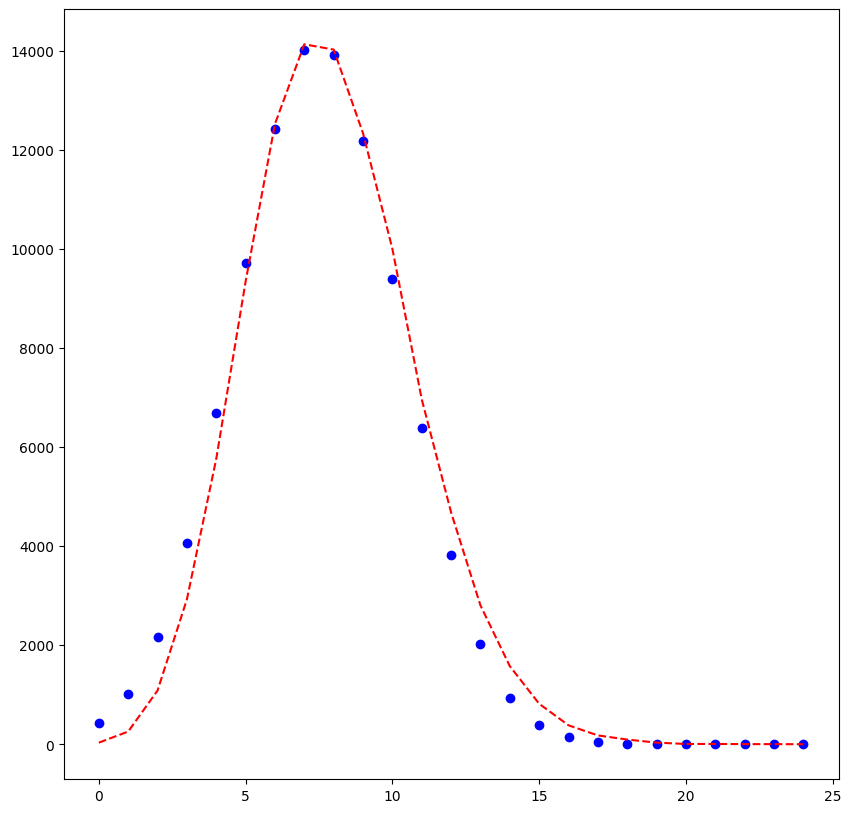

In [29]:
distribution_query = 7
distribution_anchor = 6
abundancy1 = parameters[distribution_query, "abudancy"]
abundancy2 = parameters[distribution_anchor, "abudancy"]
simulation_number = 10000


data = sum(truth_table[:,truth_table_index .== distribution_query ,distribution_anchor], dims=2)
data = reshape(data, length(data))
sample_size = length(data)

expectancy = colocalization_modelisation.colocalization_expectancy(
    abundancy1,
    abundancy2,
    volume
)
distrib_std = colocalization_modelisation.colocalization_std(
    abundancy1,
    abundancy2,
    volume
)

obs_hist = fit(Histogram, data, nbins = maximum(data)+1)
sample_size = length(obs_hist.weights)
expected_distribution = Normal(expectancy, distrib_std)

    expected_probs = Array{Float64,1}(undef, length(obs_hist.weights))
    for i in 1:(length(obs_hist.weights))
        b0 = obs_hist.edges[1][i]
        b1 = obs_hist.edges[1][i+1]
        expected_probs[i] = cdf(expected_distribution, b1) - cdf(expected_distribution, b0)
    end

expected_counts = expected_probs .* sum(obs_hist.weights)
obs_discrepancy = chisq_dist(expected_probs, obs_hist.weights / sum(obs_hist.weights))

println("obs_hist weights : ",obs_hist.weights)
println("expected_counts : ",expected_counts)
println("sum obs_hist weights : ",sum(obs_hist.weights))
println("sum expected_counts : ",sum(expected_counts))
println("sum expected_probs : ", sum(expected_probs))
println("observed discrepancy : ", obs_discrepancy)


fig = figure(figsize=(10,10))
plot(obs_hist.edges[1][1:length(obs_hist.edges[1])-1], expected_counts, "ob")
plot(obs_hist.edges[1][1:length(obs_hist.edges[1])-1], obs_hist.weights, "--r")
fig

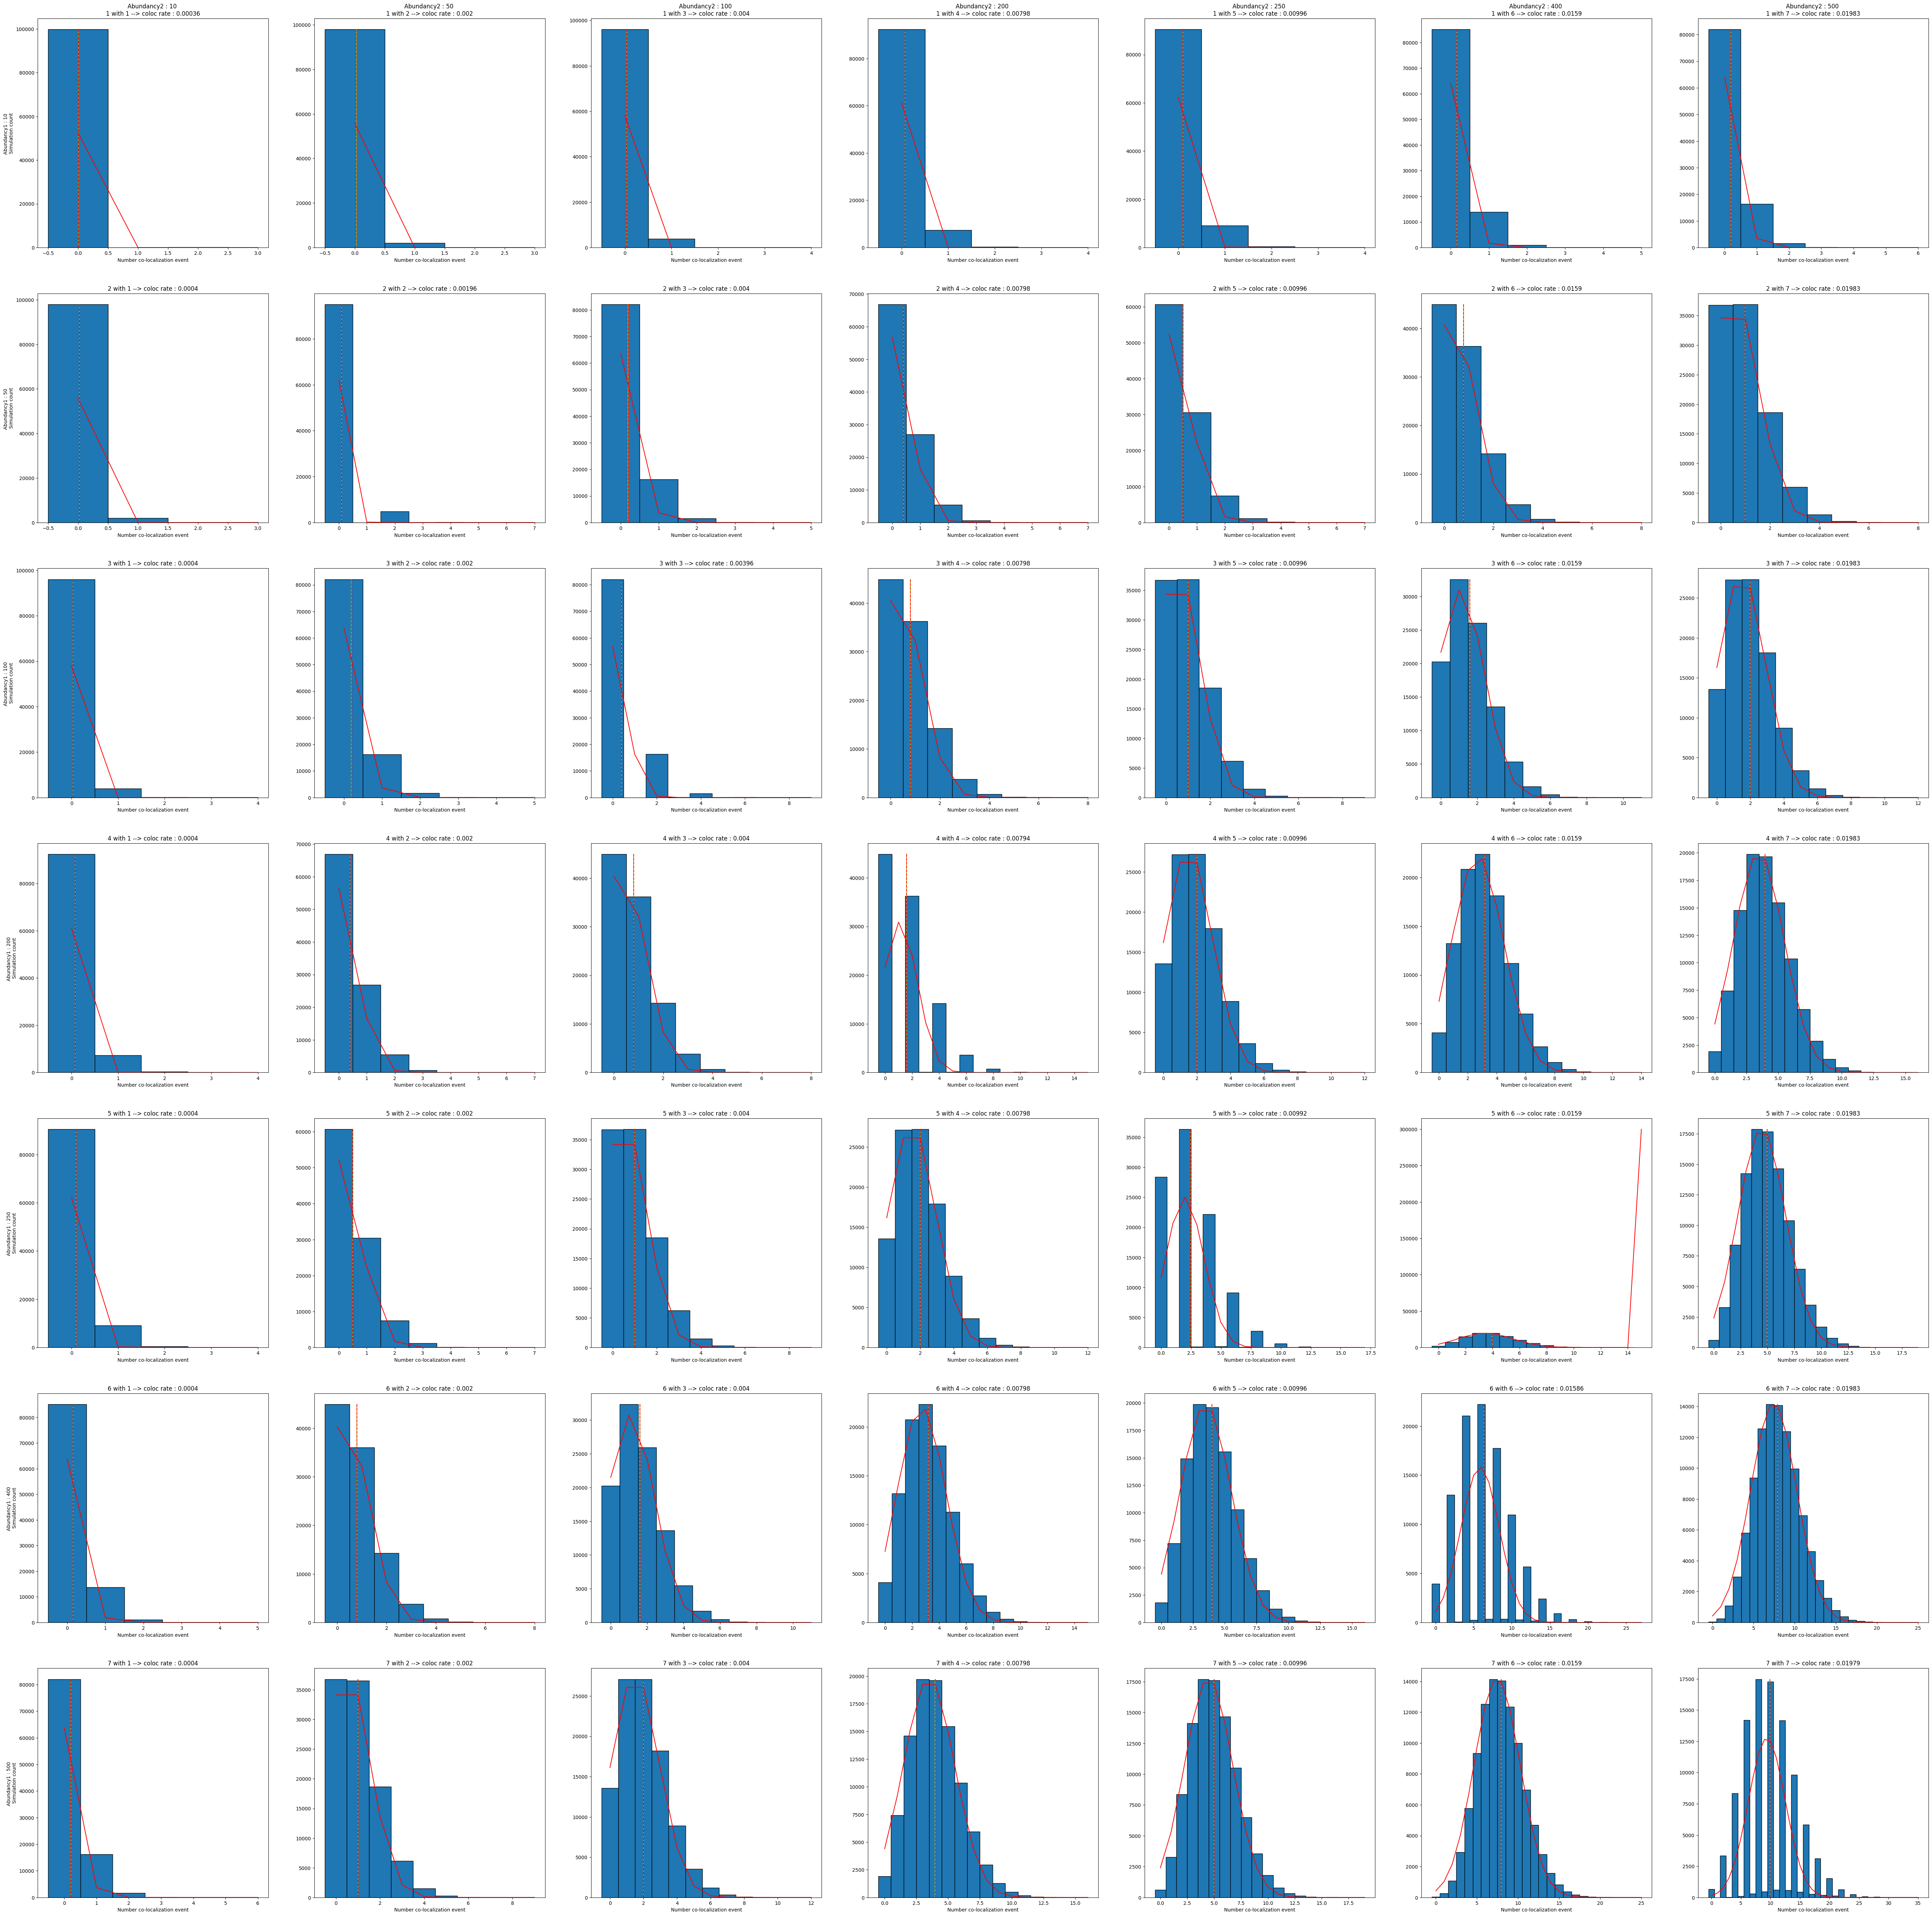

In [17]:
fig, all_axes = subplots(distribution_number,distribution_number, 
figsize=(70,70),
)

ax_idx = 1
for col in 1:distribution_number
    for line in 1:distribution_number
        distribution_query = line
        distribution_anchor = col
        
        abundancy1 = parameters[distribution_query, "abudancy"]
        abundancy2 = parameters[distribution_anchor, "abudancy"]

        if distribution_anchor == distribution_query
            expectancy = colocalization_modelisation.self_colocalization_expectancy(
                abundancy1,
                volume
            )
            std_value = colocalization_modelisation.self_colocalization_std(
                abundancy1,
                volume
            )

        else
            expectancy = colocalization_modelisation.colocalization_expectancy(
                abundancy1,
                abundancy2,
                volume
            )
            std_value = colocalization_modelisation.colocalization_std(
                abundancy1,
                abundancy2,
                volume
            )
        end
        
        expected_distribution = Normal(expectancy, std_value)

        data = sum(truth_table[:,truth_table_index .== distribution_query ,distribution_anchor], dims=2)

        #Plotting
        ax = all_axes[ax_idx]

        counts, bins = ax.hist(
            data, 
            bins = 0:maximum(data) + 1, 
            align= "left",
            edgecolor = "black",
            density=0
            )
        ax.plot([mean(data), mean(data)], [0,maximum(counts)], "y")
        ax.plot([expectancy, expectancy], [0,maximum(counts)], "--r")
        counts = pad_right(counts, length(bins), 0)
        counts = Int.(round.(counts))
        
        xrange = bins[1]:last(bins)
        # expected_counts = pdf.(expected_distribution, xrange)
        
        expected_probs = Array{Float64,1}(undef, length(counts))
        for i in 1:(length(counts)-1)
            b0 = bins[i]
            b1 = bins[i+1]
        expected_probs[i] = cdf(expected_distribution, b1) - cdf(expected_distribution, b0)
        end

    expected_counts = expected_probs .* sum(counts)
        
        ax.plot(xrange, expected_counts, "r")


        #axis labels
        coloc_rate = expectancy / abundancy1
        coloc_rate= round(coloc_rate, digits= 5)
        if col == 1 
            ax.set_ylabel("Abundancy1 : $abundancy1 \nSimulation count")
        end
        if line == 1
            ax.set_title("Abundancy2 : $abundancy2 \n$distribution_query with $distribution_anchor --> coloc rate : $coloc_rate") 
        else
            ax.set_title("$distribution_query with $distribution_anchor --> coloc rate : $coloc_rate") 
            
        end
        ax.set_xlabel("Number co-localization event")
        ax_idx = ax_idx +1
    end
end
fig.savefig(output_path*"/Random co-localization simulation/output/paircolocalization.png")
fig